<a href="https://colab.research.google.com/github/Albly/Tissue_segmentation/blob/alex_branch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning
!pip install --quiet wandb

#!wget https://raw.githubusercontent.com/Albly/Tissue_segmentation/main/loss.py
#!wget https://raw.githubusercontent.com/Albly/Tissue_segmentation/main/pl.py

     |████████████████████████████████| 582 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 136 kB 39.6 MB/s 
     |████████████████████████████████| 398 kB 66.0 MB/s 
     |████████████████████████████████| 1.1 MB 52.7 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 144 kB 49.4 MB/s 
     |████████████████████████████████| 271 kB 15.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 144 kB 61.4 MB/s 
     |████████████████████████████████| 181

In [2]:
import torch
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import glob
import h5py
import cv2
import math
import pytorch_lightning as pl
import random
import wandb
import albumentations as A
from copy import copy

train_path = 'tissue-segment/'

In [3]:
USE_WANDB_LOGGER = False
if USE_WANDB_LOGGER:
    wandb.init(project="Tissue_segmentation", entity="sk_team")

In [4]:
'''Unzip dataset on your drive or add shortcut from shared files'''
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Tissue_segmentation_project

#!git clone https://github.com/Albly/Tissue_segmentation.git

Mounted at /content/drive
/content/drive/MyDrive/Tissue_segmentation_project


In [261]:
class Tissue_Dataset(Dataset):
    def __init__(self, path, transform = None, n_crop_size = (1024,1024), n_patch_size = (256,256)):
        masks_name = glob.glob(path+'/*mask.jpg')
        image_names = glob.glob(path+'/*[!mask].jpg')
        
        assert len(masks_name) == len(image_names), 'Different amount of images and masks'

        masks_tmp, images_tmp = [], []
        for mask in masks_name: masks_tmp.append(mask[:-9])     # discard _mask.jgp 
        for image in image_names: images_tmp.append(image[:-4]) # discard .jpg
        
        assert all(item in masks_tmp for item in images_tmp) , 'Different files' # check that subsest are the same
        
        self.files = images_tmp
        self.transform = transform
        self.n_crop_size = n_crop_size
        self.n_patch_size = n_patch_size
        self.mode = 'train'

    def patch_sample(self, image, mask, patch_sizes):
        patch_h, patch_w = patch_sizes[0], patch_sizes[1]
        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,0),0)
        
        n,c,h,w = image.shape
        out_image = torch.permute(image.unfold(2, patch_w, patch_w).unfold(3, patch_h, patch_h), (0,2,3,1,4,5)).reshape(-1,c,patch_w,patch_h)
        out_mask = torch.permute(mask.unfold(2, patch_w, patch_w).unfold(3, patch_h, patch_h), (0,2,3,1,4,5)).reshape(-1,1,patch_w,patch_h)
        
        out_mask = torch.squeeze(out_mask, dim =1)

        return out_image, out_mask

    def __len__(self):
        return len(self.files)
    

    def __getitem__(self, idx):
        image = cv2.imread(self.files[idx]+'.jpg')  # load image in grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.files[idx]+'_mask.jpg', cv2.IMREAD_GRAYSCALE)   # load mask in grayscae
        mask = cv2.threshold(mask,122,255,cv2.THRESH_BINARY)[1]     # binirize mask to [0;255] using threshold 122
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = torch.tensor(np.transpose(transformed['image'], (2,0,1)))
            mask = torch.tensor(transformed['mask'])    
        
        if self.mode == 'train':
            image , mask = self.patch_sample(image, mask, self.n_patch_size)
        
        image, mask = image/255.0 , mask/255.0

        return  image.type(torch.float32), mask.type(torch.float32)


def get_transforms(train_area_size = 1024, test_area_size = 1024):
    '''returns augmentations transforms for both datasets
       Applies patch sampling to data.
    '''

    train_transform = A.Compose([
        A.RandomCrop(height=train_area_size, width=test_area_size, always_apply = True),
        A.HorizontalFlip(always_apply = False, p = 0.5),
        A.VerticalFlip(always_apply = False, p = 0.5),
        A.RandomRotate90(p=0.5),
        #A.Transpose(p=0.5),
        #A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        #A.GridDistortion(p=0.5),
        #A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
        #TODO: add other transfroms
    ])
    
    test_transform = A.Compose([
        A.RandomCrop(height = test_area_size, width = test_area_size, always_apply = True)
    ])

    return train_transform, test_transform


def prepare_DataLoaders(path, train_test_split = 0.9, batch_size = (3,1), n_crops = 20, transforms = (None, None)):
    fullDataset = Tissue_Dataset(path, transforms[0], (1024,1024), (256,256))  # get full dataset and assign train augmentation 
    train_size = int(train_test_split * len(fullDataset))  
    test_size = len(fullDataset) - train_size
    
    # split dataset to 2 subsets
    trainDataset, testDataset = torch.utils.data.random_split(fullDataset, [train_size, test_size])
    testDataset.dataset = copy(fullDataset)             # both subsets uses the same dataset object. Need a copy for using different transfroms
    testDataset.dataset.transform = transforms[1]       # assign test transform
    testDataset.dataset.mode = 'test'
    # construnct dataLoaders
    trainLoader = DataLoader(trainDataset, batch_size = batch_size[0], shuffle = True)
    testLoader = DataLoader(testDataset, batch_size = batch_size[1], shuffle = True)
    return trainLoader, testLoader

In [262]:
train_transform, test_transform = get_transforms(train_area_size = 1024,
                                                test_area_size = 1024)

trainLoader, testLoader = prepare_DataLoaders(path = train_path,
                                              train_test_split = 0.9,
                                              batch_size = (3,1),
                                              transforms = (train_transform, test_transform)
                                              )

Train loader
Shape of images is : torch.Size([3, 16, 3, 256, 256])
Shape of masks is : torch.Size([3, 16, 256, 256])
Test loader
Shape of images is : torch.Size([1, 3, 1024, 1024])
Shape of masks is : torch.Size([1, 1024, 1024])


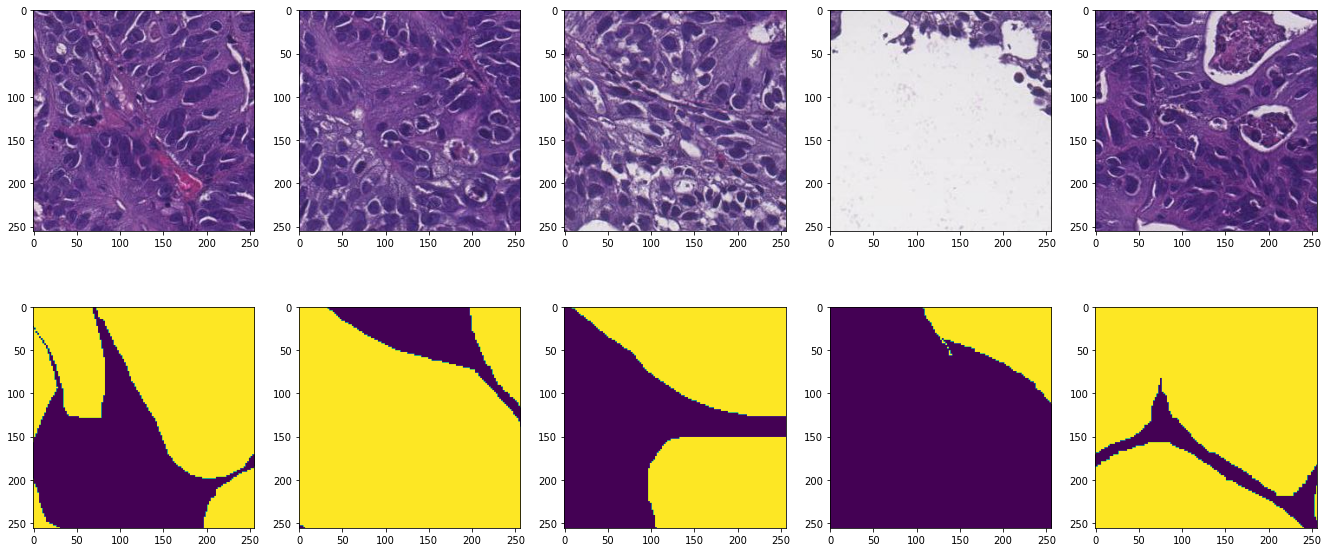

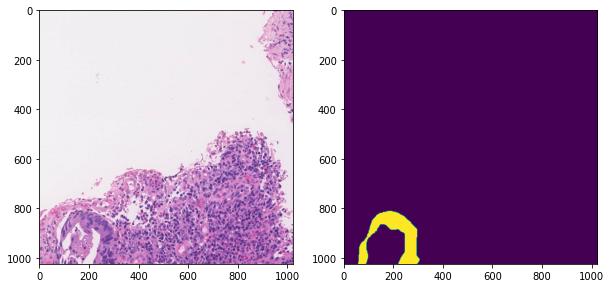

In [268]:
plt.figure(figsize=(23,10))
image = []
mask = []
for image,mask in trainLoader:
    print('Train loader')
    print('Shape of images is :', image.shape)
    print('Shape of masks is :', mask.shape)

    plt.subplot(2,5,1); plt.imshow(image[0,0].T)
    plt.subplot(2,5,2); plt.imshow(image[0,1].T)
    plt.subplot(2,5,3); plt.imshow(image[0,2].T)
    plt.subplot(2,5,4); plt.imshow(image[0,3].T)
    plt.subplot(2,5,5); plt.imshow(image[0,4].T)

    plt.subplot(2,5,6); plt.imshow(mask[0,0].T)
    plt.subplot(2,5,7); plt.imshow(mask[0,1].T)
    plt.subplot(2,5,8); plt.imshow(mask[0,2].T)
    plt.subplot(2,5,9); plt.imshow(mask[0,3].T)
    plt.subplot(2,5,10); plt.imshow(mask[0,4].T)
    break

print('==========================================')
plt.figure(figsize=(10,10))
for image,mask in testLoader:
    print('Test loader')
    print('Shape of images is :', image.shape)
    print('Shape of masks is :', mask.shape)
    plt.subplot(1,2,1); plt.imshow(image[0].T)
    plt.subplot(1,2,2); plt.imshow(mask[0].T)
    break

In [ ]:
#!git clone https://github.com/Albly/Tissue_segmentation.git

Cloning into 'Tissue_segmentation'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 57 (delta 19), reused 34 (delta 9), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [269]:
import torch
from Tissue_segmentation.loss import *

size = 3
TR = torch.randint(0,2,[size,size],dtype=torch.uint8)*255
PR = torch.randint(0,2,[size,size],dtype=torch.uint8)*255

TP,TN,FP,FN = calc_val_data_dice(TR, PR)
dice_score = calc_val_loss_dice(TP,TN,FP,FN)

I,U,T = calc_val_data_IoU(TR,PR)
IoU,Acc = calc_val_loss_IoU(I,U,T)

print("TP",TR)
print("PR",PR)
print("TP",TP)
print("TN",TN)
print("FP",FP)
print("FN",FN)
print("dice_score",dice_score)
print("IoU,Acc",IoU,Acc)

TP tensor([[  0,   0, 255],
        [255,   0, 255],
        [  0,   0,   0]], dtype=torch.uint8)
PR tensor([[255,   0, 255],
        [255,   0, 255],
        [  0, 255,   0]], dtype=torch.uint8)
TP tensor([[False, False,  True],
        [ True, False,  True],
        [False, False, False]])
TN tensor([[False,  True, False],
        [False,  True, False],
        [ True, False,  True]])
FP tensor([[ True, False, False],
        [False, False, False],
        [False,  True, False]])
FN tensor([[False, False, False],
        [False, False, False],
        [False, False, False]])
dice_score tensor(0.7500)
IoU,Acc tensor([0.6667, 0.6000]) tensor([0.6667, 1.0000])
